In [1]:
import pandas as pd
import re
import logging
import numpy as np
from sklearn.svm import LinearSVC
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set()
import pymorphy2

from importlib import reload # in order to use basicConfig with IPython
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', 
                    level=logging.INFO, 
                    datefmt='%I:%M:%S')

from jupyterthemes import jtplot #внешний вид ноутбука и графиков
jtplot.style(theme='onedork')
%matplotlib inline

c:\users\mytas\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def lemmatize(string, morph=None):
    lemmatized = [morph.parse(w)[0].normal_form 
                  for w in word_tokenize(string)]
    return ' '.join(lemmatized)


def evaluate(y_true, y_pred):
    print("Accuracy: {}".format(metrics.accuracy_score(y_true, y_pred)))
    print(metrics.classification_report(y_true, y_pred))
    

def plot_matrix(y, pred):
    mat = metrics.confusion_matrix(y, pred)
    correct = mat.diagonal().sum()
    sns.set_context("talk")
    plt.figure(figsize=(5,5))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
                cmap='viridis', 
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    plt.xlabel('True polarity')
    plt.ylabel('Predicted polarity')
    plt.title(('Confusion matrix'), fontsize=14, fontweight='bold');
    
    
pos_map={
    'NOUN': '_NOUN',
    'VERB': '_VERB', 
    'INFN': '_VERB',
    'GRND': '_VERB', 
    'PRTF': '_VERB', 
    'PRTS': '_VERB',
    'ADJF': '_ADJ', 
    'ADJS': '_ADJ',
    'ADVB': '_ADV',
    'PRED': '_ADP',
    'NUMR': '_NUM'
}


def map_pos(pos_map, pos):
    return pos_map.get(pos, "_X")


def make_bag(string, model, mode='sum'):
    pos_words = [word + map_pos(pos_map, str(morph.parse(word)[0].tag.POS)) \
                 for word in string.split()]    
    vectors = [model[w] if w in model.vocab else np.zeros(300) for w in pos_words]
    if mode == 'sum':
        return sum(vectors)
    return vectors

## Prepare data

In [11]:
MIN_CONF = 95
LEMMATIZE = True
FRACTION = 1
W2V = False
# W2V = 'ruscorpora_upos_skipgram_300_5_2018.vec.gz'
ONLY_W2V = False

04:31:27 - INFO - 9778 observations in total
04:31:27 - INFO - 7271 (74.36%) observations with confindence > 95.00%
04:31:43 - INFO - 7271 observations lemmatized


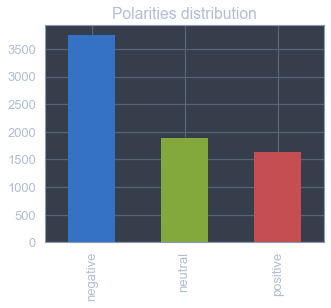

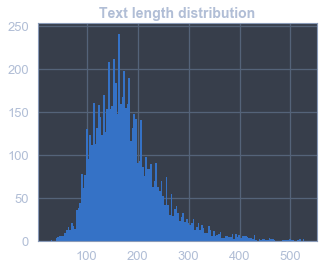

In [12]:
raw = pd.read_csv('../aggregated_results_pool_2327280__2018_08_23.tsv', sep='\t')
raw = raw.sample(frac=FRACTION)
raw['CONFIDENCE:polarity'] = raw['CONFIDENCE:polarity'].map(lambda x: float(x[0:-1]))
obs_total = raw.shape[0]
logging.info("{} observations in total".format(obs_total))
raw = raw[raw['CONFIDENCE:polarity'] > MIN_CONF]
obs_high_conf = raw.shape[0]
logging.info("{} ({:.2%}) observations with confindence > {:.2f}%".format(obs_high_conf, 
                                                              obs_high_conf/obs_total, 
                                                              MIN_CONF))
raw = raw.fillna(' ')
X = (raw['INPUT:title'] + ' ' + raw['INPUT:text']).str.lower()
X = X.str.replace('\W', ' ').str.replace(' +', ' ')
y = raw['OUTPUT:polarity']

if LEMMATIZE:
    morph = pymorphy2.MorphAnalyzer()
    X = X.apply(lemmatize, morph=morph)
    logging.info('{} observations lemmatized'.format(X.shape[0]))
    
y.value_counts().plot(kind='bar', title="Polarities distribution", figsize=(5,4));

lens = np.array([len(t) for t in X]) 
plt.figure(figsize=(5,4))
plt.hist(lens, bins=150)
plt.title(('Text length distribution'), fontsize=14, fontweight='bold');

## Build model

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                             analyzer='word', 
                             lowercase=True,
                             tokenizer=word_tokenize, 
                             min_df = 10, 
                             max_df = 0.7,
                             max_features = 5000)

#this is actually incorrect, but i don't care for now
X_vec = vectorizer.fit_transform(X)

logging.info('{} observations, {} features'.format(X_vec.shape[0], X_vec.shape[1]))

features = vectorizer.get_feature_names()
excluded = vectorizer.stop_words_
logging.info('Random features: {}'.format(
    ' | '.join(np.array(features)[np.random.randint(0, len(features), 10)])))

logging.info('Excluded {} tokens'.format(len(vectorizer.stop_words_)))
logging.info('Random excluded: {}'.format(
    ' | '.join(np.array(list(excluded))[np.random.randint(0, len(excluded), 10)])))

if W2V:
    logging.info('Loading W2V...')
    try:
        vecmodel.vocab
    except NameError:
        vecmodel = KeyedVectors.load_word2vec_format(W2V, encoding='utf-8')
    logging.info('W2V model loaded')
    X_wv = X.apply(make_bag, model=vecmodel).reset_index(drop=True)
    X_wv = np.matrix([*np.array(X_wv.values)])
    X_vec = np.concatenate([X_wv, X_vec.todense()], axis=1)
    logging.info('W2V applied')

if ONLY_W2V:
    X_vec = X_wv
    
logging.info('{} features'.format(X_vec.shape[1]))

04:31:54 - INFO - 7271 observations, 4084 features
04:31:54 - INFO - Random features: 500 | фирма | история | лука | подозреваться в | площадка в | гу мвд | грузовик | 40 | на
04:31:54 - INFO - Excluded 263818 tokens
04:31:54 - INFO - Random excluded: чечня предложить | зависимость от градообразующий | жара главный синоптик | раз ниже | пока безрезультатно идти | дать старт традиционный | ситуация с футбольный | на помощь пожилой | соборный площадь делать | за крестный ход
04:31:54 - INFO - 4084 features


Train:
Accuracy: 0.8729139922978177
             precision    recall  f1-score   support

   negative       0.92      0.93      0.93      2793
    neutral       0.83      0.81      0.82      1429
   positive       0.82      0.81      0.81      1231

avg / total       0.87      0.87      0.87      5453

Test:
Accuracy: 0.7882288228822882
             precision    recall  f1-score   support

   negative       0.88      0.89      0.89       956
    neutral       0.67      0.69      0.68       459
   positive       0.69      0.65      0.67       403

avg / total       0.79      0.79      0.79      1818



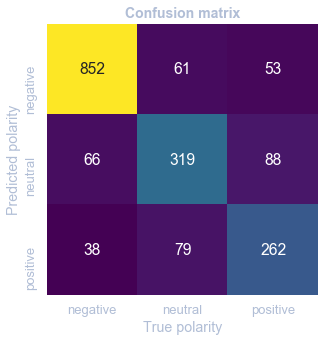

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.25, random_state=1)
model = LinearSVC(C=0.3, penalty='l2', dual=True, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

print('Train:')
pred_train = model.predict(X_train)
evaluate(y_train, pred_train)

print('Test:')
pred_test = model.predict(X_test)
evaluate(y_test, pred_test)
plot_matrix(y_test, pred_test)

In [15]:
with open('pa_vect.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('pa_cl.pkl', 'wb') as f:
    pickle.dump(model, f)